# **Reproduce SAS Logistic Regression with Python**

This is a notebook I prepared to show that I can understand and translate SAS code to Python/Sklearn, PySpark, and pure numpy. Hence, the purpose is to reproduce the SAS output (here the ROC curve), not to build a good model.

1. [**Prepare the data with Pandas**](#pandas)  
2. [**Logistic Regression with Scikit-Learn**](#sklearn)  
    2.1 [*LogisticRegressionCV*](#cv)  
    2.2 [*LogisticRegression, with C=1e8*](#cinf)  
3. [**Logistic Regression with StatsModel**](#sm)  
4. [**Logistic Regression with Pyspark and the ML API, regParam=1e-8**](#spark)  
5. [**Logistic Regression Implemented with Numpy and (stochastic) gradient descent**](#np)

Please see the SAS example [here](https://blogs.sas.com/content/iml/2018/11/14/compare-roc-curves-sas.html).
Note: 
- The output of 2.1 is different from the SAS output, since SAS does not apply regulation.
- The second output of section 5 is also different from the SAS one, due to the randomness of the stochastic gradient desent optimization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score

#plt.style.use('ggplot')  # plt.style.available
plt.style.use('fivethirtyeight')

### **Prepare the data with Pandas**
<a id='pandas'></a>

In [2]:
# data string copied from SAS
data = """
3.0 5.8 10 0   3.2 6.3  5 1   3.9 6.8  3 1   2.8 4.8  6 0 
3.2 5.8  3 1   0.9 4.0  5 0   2.5 5.7  8 0   1.6 5.6  5 1 
3.8 5.7  5 1   3.7 6.7  6 1   3.2 5.4  4 1   3.8 6.6  6 1 
4.1 6.6  5 1   3.6 5.7  5 1   4.3 7.0  4 1   3.6 6.7  4 0 
2.3 4.4  6 1   4.2 7.6  4 0   4.0 6.6  6 0   3.5 5.8  6 1 
3.8 6.8  7 1   3.0 4.7  8 0   4.5 7.4  5 1   3.7 7.4  5 1 
3.1 6.6  6 1   4.1 8.2  6 1   4.3 7.0  5 1   4.3 6.5  4 1 
3.2 5.1  5 1   2.6 4.7  6 1   3.3 6.8  6 0   1.7 4.0  7 0 
3.7 6.1  5 1   3.3 6.3  7 1   4.2 7.7  6 1   3.5 6.2  5 1 
2.9 5.7  9 0   2.1 4.8  7 1   2.8 6.2  8 0   4.0 7.0  7 1 
3.3 5.7  6 1   3.7 6.9  5 1   3.6 6.6  5 1
"""

In [3]:
data = np.array(data.split(), dtype=float).reshape((-1,4))

In [4]:
df = pd.DataFrame(data=data, columns="alb tp totscore popind".split())

In [5]:
df.iloc[:2,:]
df.totscore = 10 - df.totscore  # same preprocessing as SAS
df.popind = 1-df.popind         # SAS uses event=0, I directly switch 0 and 1 values
df.iloc[:2,:4]

X = df.iloc[:,:3].values
y_true = df.iloc[:,3:].values.ravel()

,alb,tp,totscore,popind
0,3.0,5.8,10.0,0.0
1,3.2,6.3,5.0,1.0


,alb,tp,totscore,popind
0,3.0,5.8,0.0,1.0
1,3.2,6.3,5.0,0.0


In [6]:
def roc_plot(y_true, y_pred_prob):
    fpr, tpr, thr = roc_curve(y_true, y_pred_prob)

    plt.plot(fpr,tpr)
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve, AUR={0:.2f}'.format(roc_auc_score(y_true, y_pred_prob)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show();

### **Logistic Regression with Scikit-Learn**
<a id='sklearn'></a>

#### **LogisticRegressionCV**
<a id='cv'></a>

LogisticRegressionCV(Cs=9, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True,
                     scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=0)

1.0E-04 0.784921
1.0E-03 0.784921
1.0E-02 0.784921
1.0E-01 0.784921
1.0E+00 0.759524
1.0E+01 0.696825
1.0E+02 0.696825
1.0E+03 0.696825
1.0E+04 0.696825
coefs: [-9.38876035e-01 -5.44889206e-04 -5.06364202e-04 -1.23229702e-03]


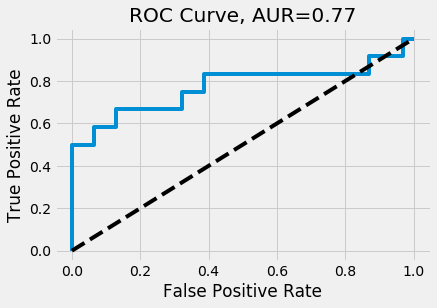

In [7]:
logregcv = LogisticRegressionCV(Cs=9, cv=5, scoring='roc_auc')
logregcv.fit(X, y_true)

aucs = logregcv.scores_[1].mean(axis=0)
for c, auc in zip(logregcv.Cs_, aucs):
    print("{0:6.1E} {1:8.6f}".format(c, auc))

print('coefs:', np.concatenate([logregcv.intercept_, logregcv.coef_[0]]))

y_pred = logregcv.predict(X)
y_pred_prob = logregcv.predict_proba(X)

roc_plot(y_true, y_pred_prob[:,1])

#### **LogisticRegression, with C=1e8**
<a id='cinf'></a>

LogisticRegression(C=100000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

coefs: [ 3.65930085 -0.98468549  0.2050126  -0.6679895 ]


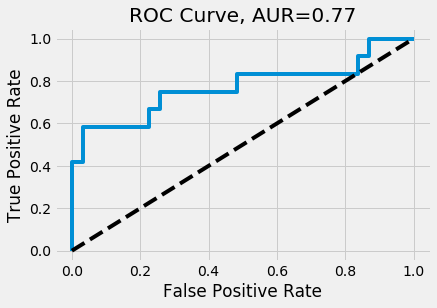

In [8]:
logreg = LogisticRegression(C=1e8)  # to mimic SAS
logreg.fit(X, y_true)

print('coefs:', np.concatenate([logreg.intercept_, logreg.coef_[0]]))

y_pred = logreg.predict(X)
y_pred_prob = logreg.predict_proba(X)

roc_plot(y_true, y_pred_prob[:,1])

### **Logistic Regression with StatsModel**
<a id='sm'></a>

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   43
Model:                          Logit   Df Residuals:                       39
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 May 2020   Pseudo R-squ.:                  0.2233
Time:                        16:28:19   Log-Likelihood:                -19.774
converged:                       True   LL-Null:                       -25.459
Covariance Type:            nonrobust   LLR p-value:                  0.009884
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6593      2.529      1.447      0.148      -1.298       8.617
alb           -0.9847      0.826     -1.192      0.233      -2.604       0.634
tp             0.2050      0.659      0.311      0.7

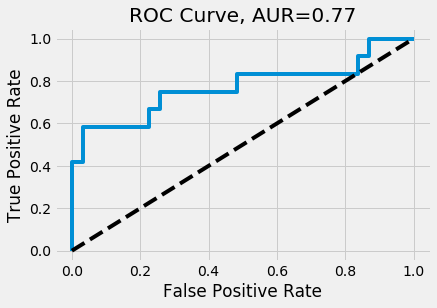

In [9]:
# add the interception
#logit = sm.Logit(y_true, np.hstack([np.ones(X.shape[0]).reshape((-1,1)), X]))
X = df.iloc[:,:3]
X_const = sm.add_constant(X)
#X['intercept'] = 1.0
logit = sm.Logit(y_true, X_const)
result = logit.fit(method='lbfgs')

print(result.summary())
print()
print(result.summary2())

y_pred_prob2 = result.predict(X_const)

roc_plot(y_true, y_pred_prob2)

### **Logistic Regression with Pyspark and the ML API, regParam=1e-8**
<a id='spark'></a>

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import udf

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression as LogisticRegression_sp

spark=SparkSession.builder.appName('logreg').getOrCreate()

In [11]:
def getType(t):
    if   t == 'datetime64[ns]': return DateType()
    elif t == 'int64': return LongType()
    elif t == 'int32': return IntegerType()
    elif t == 'float64': return FloatType()
    else: return StringType()
    
def getField(string, t):
    try: typ = getType(t)
    except: typ = StringType()
    return StructField(string, typ)

def fromPD(spark, df_pd):
    columns = list(df_pd.columns)
    typs = list(df_pd.dtypes)
    structs = []
    for col, typ in zip(columns, typs): 
        structs.append(getField(col, typ))
    schema = StructType(structs)
    return spark.createDataFrame(df_pd, schema)

In [12]:
df_sp = fromPD(spark, df)
df_sp.show(5)

+---+---+--------+------+
|alb| tp|totscore|popind|
+---+---+--------+------+
|3.0|5.8|     0.0|   1.0|
|3.2|6.3|     5.0|   0.0|
|3.9|6.8|     7.0|   0.0|
|2.8|4.8|     4.0|   1.0|
|3.2|5.8|     7.0|   0.0|
+---+---+--------+------+
only showing top 5 rows



In [13]:
df_assembler = VectorAssembler(inputCols=df_sp.columns[:-1], outputCol="features")
df_sp = df_assembler.transform(df_sp)
df_sp.show(5)

+---+---+--------+------+--------------------+
|alb| tp|totscore|popind|            features|
+---+---+--------+------+--------------------+
|3.0|5.8|     0.0|   1.0|[3.0,5.8000001907...|
|3.2|6.3|     5.0|   0.0|[3.20000004768371...|
|3.9|6.8|     7.0|   0.0|[3.90000009536743...|
|2.8|4.8|     4.0|   1.0|[2.79999995231628...|
|3.2|5.8|     7.0|   0.0|[3.20000004768371...|
+---+---+--------+------+--------------------+
only showing top 5 rows



In [14]:
model_df=df_sp.select(['features','popind'])
#training_df,test_df=model_df.randomSplit([0.75,0.25])

In [15]:
log_reg=LogisticRegression_sp(labelCol='popind', regParam=1e-8).fit(model_df)
#lr_summary=log_reg.summary
#lr_summary.areaUnderROC

predictions = log_reg.transform(model_df)

#model_predictions = log_reg.evaluate(model_df)
#model_predictions.areaUnderROC

+--------------------+------+--------------------+--------------------+----------+
|            features|popind|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|[3.0,5.8000001907...|   1.0|[-1.8943221804923...|[0.13075244216348...|       1.0|
|[3.20000004768371...|   0.0|[1.54005969785258...|[0.82347340336425...|       0.0|
|[3.90000009536743...|   0.0|[3.46281355503785...|[0.96961097924828...|       0.0|
|[2.79999995231628...|   1.0|[0.78571721038846...|[0.68691099365360...|       0.0|
|[3.20000004768371...|   0.0|[2.97854806158050...|[0.95159553669478...|       0.0|
+--------------------+------+--------------------+--------------------+----------+
only showing top 5 rows



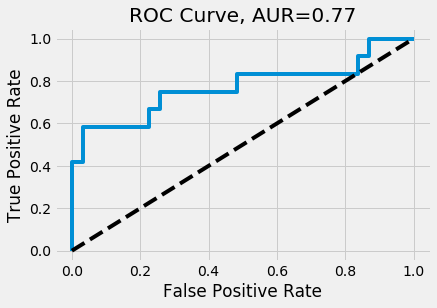

In [16]:
predictions.show(5)

prob_udf = udf(lambda probability: float(probability[-1]), FloatType())

pred = predictions.withColumn('probability', prob_udf(predictions.probability)
                             ).select(['popind', 'probability', 'prediction']
                                     ).toPandas()

roc_plot(pred.popind, pred.probability)

### **Logistic Regression Implemented with Numpy**
<a id='np'></a>

In [17]:
class logreg_numpy():
    """set nbatch to an integer<len(df) triggles SGD. 
    """
    def __init__(self, df, theta=None, learning_rate=1e-2, 
                 n_iter=1e6, early_stop=30, early_stop_tol=1e-6, nbatch=None, seed=None):
        self.df = df
        if theta is None:
            self.coef_ = np.zeros(df.shape[1])
        else:
            assert(len(theta) == df.shape[1]), "Wrong input for theta!"
            self.coef_ = np.array(theta)
            
        self.lr = learning_rate
        self.n_iter = int(n_iter)
        
        self.early_stop = early_stop
        if isinstance(self.early_stop, int):
            pass
        else:
            self.early_stop = False
            
        self.tol = early_stop_tol
        self.nbatch = nbatch
        self.seed = seed
        self.fitted = False
        
    def fit(self):
        self.__getXy()
        # if nbatch is given, use sgd, n_iteration becomes n_epoch
        if isinstance(self.nbatch, int) and self.nbatch<=len(self.y):
            self.__stochastic_gradient_descent()
        else:
            self.__gradient_descent()
        self.fitted = True
                
    def predict(self, X_test, n_dec=0):
        assert self.fitted, 'Please fit first.'
        return np.round(logreg_numpy.__sigmoid(X_test@self.coef_), n_dec)
    
    def predict_proba(self, X_test):
        return self.predict(X_test, n_dec=8)
        
    def __getXy(self):
        X = self.df.iloc[:,:-1]
        X['intercept'] = 1.0
        self.X = X.values
        self.y = self.df.iloc[:,-1].values.ravel()

    @staticmethod
    def __sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def __getCost(X, y, theta):
        m = len(y)
        h = logreg_numpy.__sigmoid( X@theta )
        epsilon = 1e-5
        cost = y.T @ np.log(h + epsilon) +  (1-y).T @ np.log(1-h + epsilon)
        return -cost/m

    @staticmethod
    def __getGradient(X,y,theta):
        return (X.T @ (logreg_numpy.__sigmoid(X@theta) - y) )/len(y)
    
    def __gradient_descent(self):
        m = len(self.y)
        self.costs = np.ones((self.n_iter,1))

        for i in range(self.n_iter):
            self.coef_ -= self.lr * logreg_numpy.__getGradient(self.X, self.y, self.coef_)
            self.costs[i] = logreg_numpy.__getCost(self.X, self.y, self.coef_)
            if self.early_stop and i > self.early_stop \
              and abs(self.costs[i]-self.costs[i-self.early_stop])<self.tol:
                self.costs = self.costs[:i]
                break
        self.n_iter = len(self.costs)

    def __stochastic_gradient_descent(self):
        self.seed =  self.seed or 42
        np.random.seed(self.seed)
        m = len(self.y)
        self.costs = np.ones((self.n_iter*(m//self.nbatch),1))
        ind = list(range(m))
                
        i = -1
        while i < self.n_iter * (m//self.nbatch):
            np.random.shuffle(ind)
            for ib in range(0, m//self.nbatch*self.nbatch, self.nbatch):
                self.coef_ -= self.lr * logreg_numpy.__getGradient(
                                self.X[ ind[ib : ib+self.nbatch] ], 
                                self.y[ ind[ib : ib+self.nbatch] ], self.coef_)
                i += 1
                self.costs[i] = logreg_numpy.__getCost(self.X, self.y, self.coef_)
            if self.early_stop and i > self.early_stop \
              and abs(self.costs[i]-self.costs[i-self.early_stop])<self.tol:
                self.costs = self.costs[:i]
                break
        self.n_iter = len(self.costs)


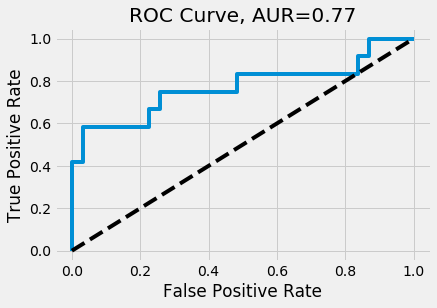

In [18]:
# gradient descent
logreg_np = logreg_numpy(df, learning_rate=0.2)
logreg_np.fit()

roc_plot(logreg_np.y, logreg_np.predict_proba(logreg_np.X) )

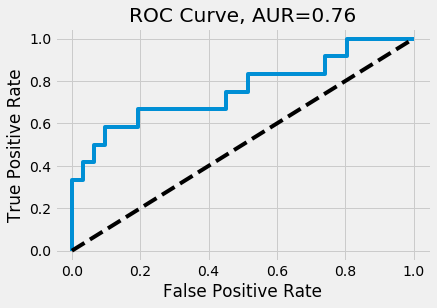

In [19]:
# stochastic gradient descent
logreg_np_sgd = logreg_numpy(df, learning_rate=0.01, nbatch=4, seed=42)
logreg_np_sgd.fit()

roc_plot(logreg_np_sgd.y, logreg_np_sgd.predict_proba(logreg_np_sgd.X) )

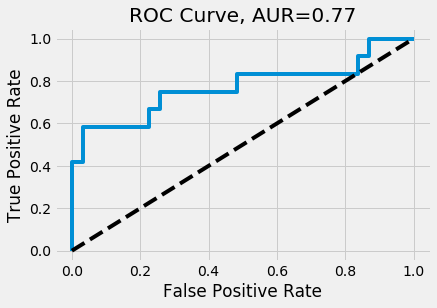

In [20]:
# stochastic gradient descent with nbatch=nsample
# should give the same results as gradient descent
logreg_np_sgd = logreg_numpy(df, learning_rate=0.01, nbatch=len(df), seed=42)
logreg_np_sgd.fit()

roc_plot(logreg_np_sgd.y, logreg_np_sgd.predict_proba(logreg_np_sgd.X) )